
Epoch 1/10


Testing        : 100%|██████████| 407/407 [00:08<00:00, 49.93it/s]


Train Loss: 2.4111 | Train Accuracy: 18.41%
Test  Loss: 2.2113 | Test  Accuracy: 19.66%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 19.66%

Epoch 2/10


Testing        : 100%|██████████| 407/407 [00:08<00:00, 49.35it/s]


Train Loss: 1.3806 | Train Accuracy: 54.59%
Test  Loss: 0.9915 | Test  Accuracy: 68.80%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 68.80%

Epoch 3/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 54.52it/s]


Train Loss: 0.8599 | Train Accuracy: 72.94%
Test  Loss: 0.7802 | Test  Accuracy: 75.33%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 75.33%

Epoch 4/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 57.51it/s]


Train Loss: 0.7191 | Train Accuracy: 77.28%
Test  Loss: 0.6891 | Test  Accuracy: 78.87%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 78.87%

Epoch 5/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 57.01it/s]


Train Loss: 0.6360 | Train Accuracy: 80.01%
Test  Loss: 0.6325 | Test  Accuracy: 80.26%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 80.26%

Epoch 6/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 55.19it/s]


Train Loss: 0.5789 | Train Accuracy: 81.97%
Test  Loss: 0.5834 | Test  Accuracy: 81.83%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 81.83%

Epoch 7/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 51.27it/s]


Train Loss: 0.5402 | Train Accuracy: 83.07%
Test  Loss: 0.5598 | Test  Accuracy: 82.75%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 82.75%

Epoch 8/10


Testing        : 100%|██████████| 407/407 [00:08<00:00, 50.38it/s]


Train Loss: 0.5066 | Train Accuracy: 84.19%
Test  Loss: 0.5523 | Test  Accuracy: 83.01%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 83.01%

Epoch 9/10


Testing        : 100%|██████████| 407/407 [00:08<00:00, 48.73it/s]


Train Loss: 0.4793 | Train Accuracy: 85.02%
Test  Loss: 0.5329 | Test  Accuracy: 83.55%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 83.55%

Epoch 10/10


Testing        : 100%|██████████| 407/407 [00:07<00:00, 53.91it/s]


Train Loss: 0.4578 | Train Accuracy: 85.58%
Test  Loss: 0.5138 | Test  Accuracy: 84.43%
Current LR: 1.00e-04
✅ Nouveau meilleur modèle sauvegardé avec 84.43%


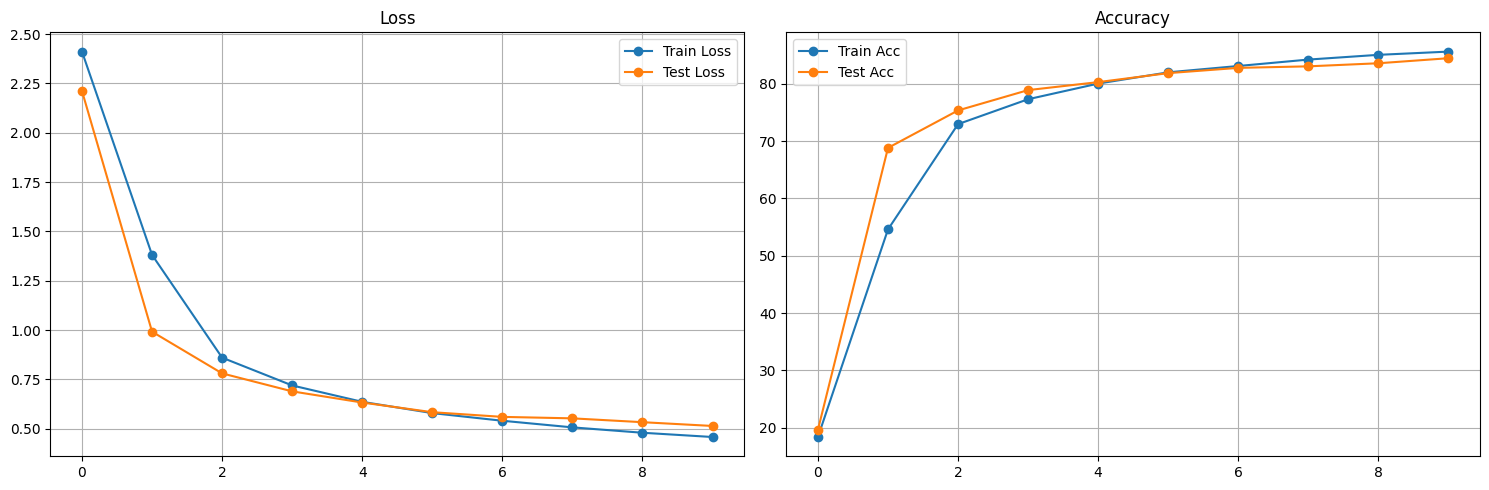


✅ Best Test Accuracy: 84.43%
Done.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.datasets import SVHN

from collections import defaultdict
import matplotlib.pyplot as plt

##########################
# Configuration des hyperparamètres
##########################

# Configuration des hyperparamètres optimisés
img_size = 32
n_channels = 3
patch_size = 8
d_model = 128
num_heads = 4
num_layers = 6
num_classes = 10   # Modifié pour SVHN
ff_dim = 512
dropout = 0.1

# Hyperparamètres d'optimisation
lr = 1e-4

batch_size = 64
num_epochs = 10

        # Nombre d'époques
num_class_images = 400     # Nombre d'images prototypes par classe (utilisé uniquement à l'entraînement)

##########################
# Modules du modèle
##########################

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.patch_embedding = nn.Conv2d(
            in_channels=n_channels,
            out_channels=d_model,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        # x shape: (N, C, H, W)
        x = self.patch_embedding(x)           # (N, d_model, H/patch_size, W/patch_size)
        x = x.flatten(2)                      # (N, d_model, num_patches)
        x = x.transpose(1, 2)                 # (N, num_patches, d_model)
        return x

class IntraAttention(nn.Module):
    def __init__(self, d_model, num_heads=16):
        super(IntraAttention, self).__init__()
        self.embed_dim = d_model
        self.attention = nn.MultiheadAttention(d_model, num_heads=num_heads, batch_first=True)
        self.projection = nn.Linear(32 * 32 * 3, d_model)  # Projection pour CIFAR-10

    def forward(self, x, class_images):
        batch_size = x.size(0)

        # Mise en forme des images de la même classe
        class_images = class_images.view(batch_size, -1, 32 * 32 * 3)  # (batch_size, num_images, flatten_dim)
        class_images_proj = self.projection(class_images)  # (batch_size, num_images, d_model)

        num_images_actual = class_images_proj.size(1)

        # Assurer la compatibilité avec MultiheadAttention
        x_proj = x.unsqueeze(1)  # (batch_size, 1, d_model)
        attn_output, _ = self.attention(x_proj, class_images_proj, class_images_proj)

        return attn_output#.squeeze(1)  # On enlève la dimension supplémentaire pour récupérer (batch_size, d_model)


class ItraAttention(nn.Module):
    def __init__(self, d_model, num_class_images=num_class_images, num_heads=8,
                 img_size=32, patch_size=8, n_channels=3, ff_dim=760, dropout=0.2, num_layers=6):
        """
        Pipeline pour extraire une représentation (prototype) à partir d'une image :
          - Patch embedding (identique à celui du ViT)
          - Ajout d’un token CLS dédié
          - Ajout d’un embedding de position
          - Passage par un Transformer Encoder (ici avec num_layers couches, par défaut 1)
          - Extraction du token CLS en sortie
        Puis, une attention multi-têtes permet d'obtenir une représentation finale
        en se basant sur les prototypes issus des images prototypes d'une classe.
        """
        super().__init__()
        self.num_class_images = num_class_images
        self.img_size = img_size
        self.patch_size = patch_size

        # Pipeline de type ViT pour extraire un prototype d'une image
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        num_patches = (img_size // patch_size) ** 2
        # Token CLS pour chaque image prototype
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # Embedding de position pour CLS + patches
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        # Transformer encoder dédié à la représentation des prototypes
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Attention multi-têtes pour combiner la représentation principale (token CLS du modèle)
        # avec celle des prototypes
        self.attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)

    def forward(self, x, class_images):
        """
        x: tensor de forme (batch, d_model) issu du token CLS du ViT principal.
        class_images: tensor de forme (batch, num_class_images, 3, img_size, img_size)
                      contenant les images prototypes pour chaque exemple.
        """
        batch_size = class_images.size(0)
        # Fusionner les dimensions batch et num_class_images pour traiter toutes les images prototypes simultanément
        # Nouveau shape : (batch * num_class_images, 3, img_size, img_size)
        class_images = class_images.view(batch_size * self.num_class_images,
                                         class_images.size(2),
                                         self.img_size,
                                         self.img_size)
        # Appliquer le patch embedding : (batch*num_class_images, num_patches, d_model)
        patches = self.patch_embedding(class_images)
        # Créer et répéter le token CLS pour chaque image prototype
        cls_tokens = self.cls_token.repeat(patches.size(0), 1, 1)  # (batch*num_class_images, 1, d_model)
        # Concaténer le token CLS aux patches
        x_prototype = torch.cat([cls_tokens, patches], dim=1)  # (batch*num_class_images, num_patches+1, d_model)
        # Ajouter l'embedding de position
        x_prototype = x_prototype + self.position_embedding
        # Passage dans le Transformer Encoder
        x_prototype = self.transformer_encoder(x_prototype)  # (batch*num_class_images, num_patches+1, d_model)
        # Extraire le token CLS comme représentation du prototype
        prototypes = x_prototype[:, 0]  # (batch*num_class_images, d_model)
        # Reshaper pour retrouver (batch, num_class_images, d_model)
        prototypes = prototypes.view(batch_size, self.num_class_images, -1)
        # Appliquer une attention multi-têtes : la requête est le token CLS du modèle principal
        x_expanded = x.unsqueeze(1)  # (batch, 1, d_model)
        attn_output, _ = self.attention(x_expanded, prototypes, prototypes)
        # Retourner le vecteur (batch, d_model)
        return attn_output.squeeze(1)

class ViT(nn.Module):
    def __init__(self, img_size, n_channels, patch_size, d_model, num_heads, num_layers,
                 num_classes, ff_dim, dropout, num_class_images=num_class_images):
        super(ViT, self).__init__()
        self.num_class_images = num_class_images
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        # Token CLS global
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # Embedding de position pour le token CLS et les patches
        num_patches = (img_size // patch_size) ** 2
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        # Transformer Encoder principal
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Branche intra-attention avec le pipeline complet pour extraire des prototypes
        self.intra_attn = IntraAttention(d_model)

        self.dropout = nn.Dropout(dropout)
        # Tête de classification combinée (CLS global + prototype)
        self.fc = nn.Linear(d_model*2 , num_classes)
        # Tête de classification utilisant uniquement le token CLS (pour l'inférence)
        self.fc_cls = nn.Linear(d_model, num_classes)

    def forward(self, x, class_images=None):
        # x shape: (N, C, H, W)
        N = x.shape[0]
        x = self.patch_embedding(x)  # (N, num_patches, d_model)
        cls_tokens = self.cls_token.repeat(N, 1, 1)  # (N, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1)  # (N, num_patches+1, d_model)
        x = x + self.position_embedding
        x = self.transformer_encoder(x)
        cls_out = x[:, 0]  # Token CLS global (N, d_model)

        if class_images is not None:
            # Utilise le pipeline intra-attention pour traiter les images prototypes
            intra_out = self.intra_attn(cls_out, class_images)  # (N, d_model)
            combined_out = torch.cat([cls_out, intra_out.mean(dim=1)], dim=1)  # (N, 2*d_model)
            #combined_out = torch.cat([cls_out, intra_out], dim=1)  # (N, 2*d_model)

            #combined_out = cls_out + intra_out  # (N, 2*d_model)

            #combined_out = self.dropout(combined_out)
            out_with_proto = self.fc(combined_out)
        else:
            out_with_proto = None

        # Tête utilisant uniquement le token CLS
        #cls_out = self.dropout(cls_out)
        out_cls = self.fc_cls(cls_out)


        if self.training:
            # Pendant l'entraînement, retourner les deux sorties pour calculer une perte combinée
            return out_with_proto, out_cls
        else:
            # En inférence, n'utiliser que la sortie de la tête CLS
            return out_cls

##############################
# Fonctions auxiliaires et DataLoader
##############################
def repare_class_images(class_images_dict, label, num_class_images=num_class_images):
    images = class_images_dict[label]
    if len(images) < num_class_images:
        repeat_factor = num_class_images // len(images) + 1
        images = torch.cat([images] * repeat_factor)
    # Shuffle the images
    perm = torch.randperm(images.size(0))
    images = images[perm]
    return images[:num_class_images]

def prepare_class_images(class_images_dict, label, num_class_images=num_class_images):
    """
    Sélectionne des images prototypes pour une classe donnée.
    Cette fonction utilise la vérité terrain et doit être utilisée UNIQUEMENT à l'entraînement.
    """
    images = class_images_dict[label]
    if len(images) < num_class_images:
        repeat_factor = num_class_images // len(images) + 1
        images = torch.cat([images] * repeat_factor)[:num_class_images]
    return images[:num_class_images]


def g_data_loaders(batch_size=batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_data = SVHN(root='./data', split='train', download=True, transform=transform)
    #extra_data = SVHN(root='./data', split='extra', download=True, transform=transform)
    test_data = SVHN(root='./data', split='test', download=True, transform=transform)

    full_train_data = ConcatDataset([train_data, extra_data])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

# Fonction pour obtenir les DataLoaders
def get_data_loaders(batch_size=batch_size):


# --- 1. Définir les transformations d'entrée ---
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])


    from torch.utils.data import ConcatDataset

# --- 2. Charger les datasets ---
    train_data = SVHN(root='./data', split='train', download=True, transform=transform)
    extra_data = SVHN(root='./data', split='extra', download=True, transform=transform)
    test_data = SVHN(root='./data', split='test', download=True, transform=transform)




    full_train_data = ConcatDataset([train_data, extra_data])

# --- 3. Créer les DataLoaders ---
# Dictionnaire des prototypes par classe
    class_images = defaultdict(list)
    for img, label in train_data:
        class_images[label].append(img)
    for label, imgs in class_images.items():
        class_images[label] = torch.stack(imgs)

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


    return trainloader, testloader , class_images
##############################
# Boucles d'entraînement et de test
##############################

def train(model, train_loader, optimizer, criterion, class_images, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training       "):
        # Préparation des prototypes (à partir de la vérité terrain – uniquement pour l'entraînement)
        prototypes = torch.stack([prepare_class_images(class_images, label.item(), num_class_images)
                                    for label in labels]).to(device)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out_with_proto, out_cls = model(images, prototypes)
        # Calcul d'une perte combinée (somme des deux pertes)
        loss_proto = criterion(out_with_proto, labels)
        loss_cls = criterion(out_cls, labels)
        loss = loss_proto + loss_cls
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        # Utilisation de la sortie de la tête CLS pour le calcul de la précision
        _, predicted = torch.max(out_cls.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return epoch_loss, train_accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing        "):
            images = images.to(device)
            labels = labels.to(device)
            # Pendant l'inférence, aucun prototype n'est fourni
            outputs = model(images, class_images=None)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

##############################
# Fonction principale
##############################



def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainloader, testloader, class_images = get_data_loaders()

    model = ViT(img_size, n_channels, patch_size, d_model, num_heads, num_layers, num_classes, ff_dim, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)#, weight_decay=weight_decay)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=patience, factor=factor, verbose=True)

    t_train_loss, t_test_loss = [], []
    t_train_acc, t_test_acc = [], []

    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train(model, trainloader, optimizer, criterion, class_images, device)
        test_loss, test_acc = test(model, testloader, criterion, device)
        #scheduler.step(test_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%')
        print(f'Test  Loss: {test_loss:.4f} | Test  Accuracy: {test_acc:.2f}%')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}')

        t_train_loss.append(train_loss)
        t_test_loss.append(test_loss)
        t_train_acc.append(train_acc)
        t_test_acc.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_vit_svhn.pth')
            print(f"✅ Nouveau meilleur modèle sauvegardé avec {best_test_acc:.2f}%")

    # Tracé
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(t_train_loss, label='Train Loss', marker='o')
    ax[0].plot(t_test_loss, label='Test Loss', marker='o')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(t_train_acc, label='Train Acc', marker='o')
    ax[1].plot(t_test_acc, label='Test Acc', marker='o')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Best Test Accuracy: {best_test_acc:.2f}%")
    print("Done.")

if __name__ == "__main__":
    main()


